In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import random
warnings.filterwarnings("ignore")

C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of images loaded: 4000


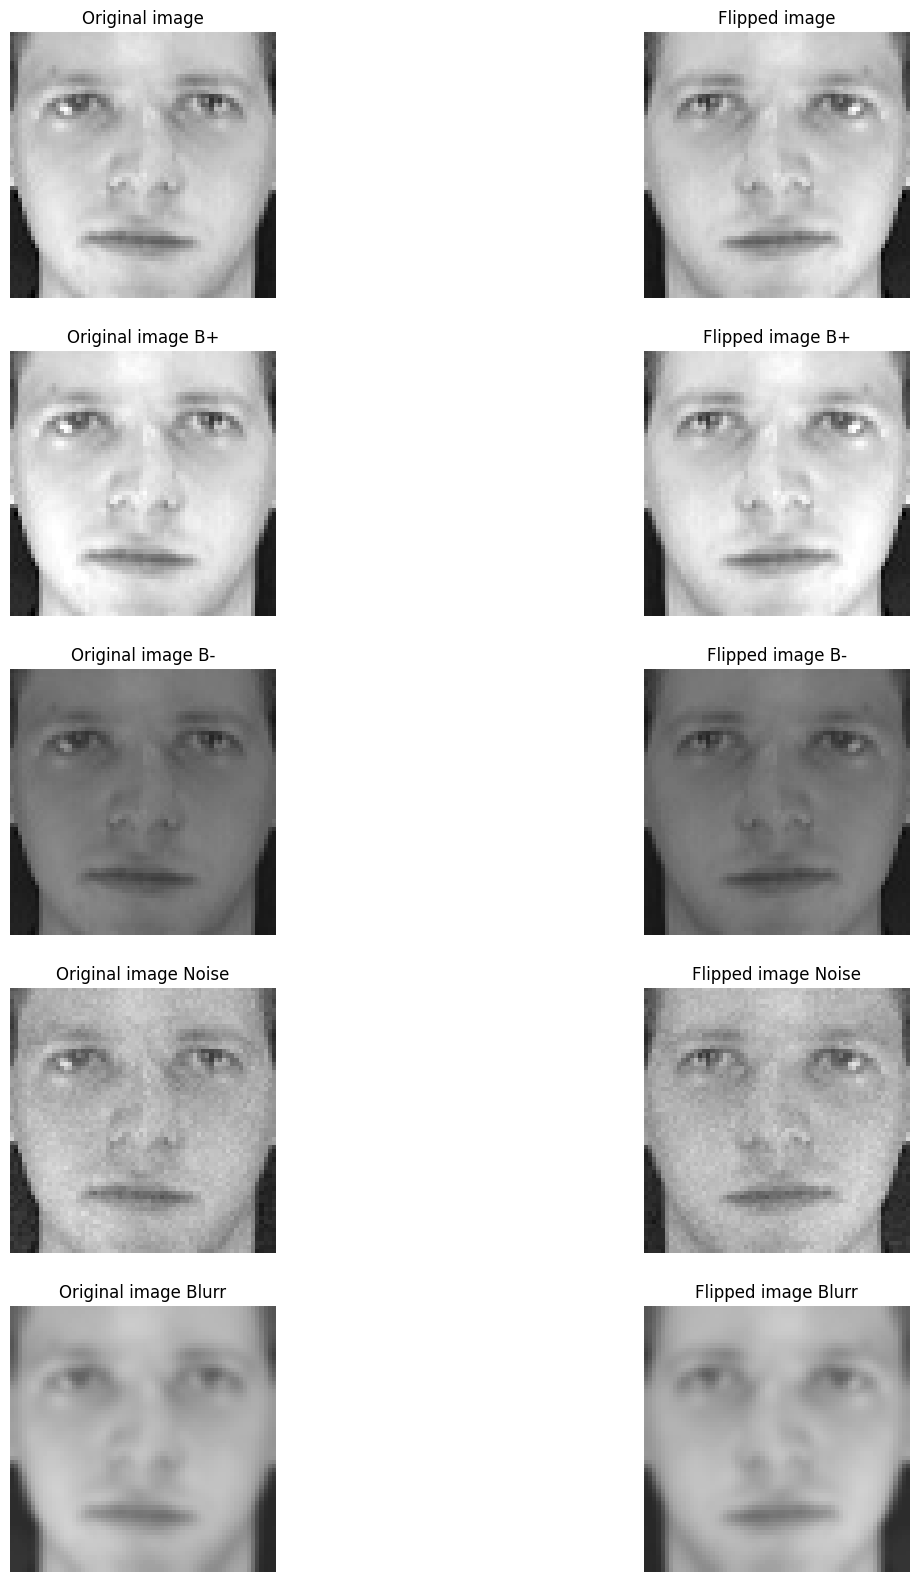

In [5]:
def load_dataset(dataset_path):
    dataset = []
    num_folders = sorted(os.listdir(dataset_path), key=lambda x: int(x))
    
    for num_folder in num_folders:
        num_folder_path = os.path.join(dataset_path, num_folder)
        for img_name in os.listdir(num_folder_path):
            img_path = os.path.join(num_folder_path, img_name)
            img = cv2.imread(img_path)
            flipped = tf.image.flip_left_right(img)
            flipped = np.array(flipped)
            flipped = cv2.cvtColor(flipped, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            random_value = random.uniform(1.2, 1.5)
            increase = np.ones((64, 64)) * random_value
            random_value = random.uniform(0.5, 0.8)
            decrease = np.ones((64, 64)) * 0.65
            
            img = img/255.0
            dataset.append((img, num_folder))
           
            flipped = flipped/255.0
            dataset.append((flipped, num_folder))
            
            bright_img = np.clip(img * increase, 0, 1)
            dataset.append((bright_img, num_folder))
            
            bright_flipped = np.clip(flipped * increase, 0, 1)
            dataset.append((bright_flipped, num_folder))
            
            bright_img2 = np.clip(img * decrease, 0, 1)
            dataset.append((bright_img2, num_folder))
            
            bright_flipped2 = np.clip(flipped * decrease, 0, 1)
            dataset.append((bright_flipped2, num_folder))
            
            random_value = random.uniform(0.02, 0.033)
            noise_img1 = img + np.random.normal(0, random_value, img.shape)
            noise_img1 = np.clip(noise_img1, 0, 1)
            dataset.append((noise_img1, num_folder))

            noise_img2 = flipped + np.random.normal(0, random_value, flipped.shape)
            noise_img2 = np.clip(noise_img2, 0, 1)
            dataset.append((noise_img2, num_folder))
            
            blur_img1 = cv2.GaussianBlur(img, (5, 5), 0)
            dataset.append((blur_img1, num_folder))
            blur_img2 = cv2.GaussianBlur(flipped, (5, 5), 0)
            dataset.append((blur_img2, num_folder))
           
    return dataset

dataset_path = "dataset"
dataset = load_dataset(dataset_path)
print("Number of images loaded:", len(dataset))
aux=[]
for img in dataset:
    aux.append(img[0])
data=np.array(aux)
labels=[]

for target in dataset:
    labels.append(target[1])
labels=np.array(labels)

fig = plt.figure(figsize=(15, 20))

plt.subplot(5, 2, 1)
plt.title('Original image')
plt.imshow(data[0], cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 2)
plt.title('Flipped image')
plt.imshow(data[1], cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 3)
plt.title('Original image B+')
plt.imshow(data[2], cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 4)
plt.title('Flipped image B+')
plt.imshow(data[3], cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 5)
plt.title('Original image B-')
plt.imshow(data[4], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(5, 2, 6)
plt.title('Flipped image B-')
plt.imshow(data[5], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(5, 2, 7)
plt.title('Original image Noise')
plt.imshow(data[6], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(5, 2, 8)
plt.title('Flipped image Noise')
plt.imshow(data[7], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(5, 2, 9)
plt.title('Original image Blurr')
plt.imshow(data[8], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(5, 2, 10)
plt.title('Flipped image Blurr')
plt.imshow(data[9], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()


## Raw data

Best accuracy: 0.9083333333333333
Best Components: 100
Best k: 3


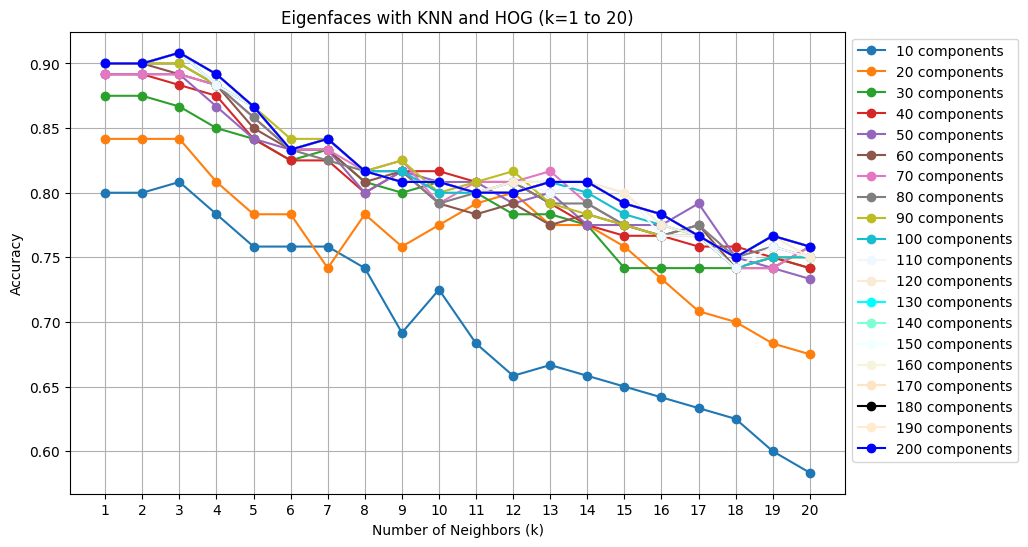

In [3]:
def load_dataset(dataset_path):
    dataset = []
    num_folders = sorted(os.listdir(dataset_path), key=lambda x: int(x))
    
    for num_folder in num_folders:
        num_folder_path = os.path.join(dataset_path, num_folder)
        for img_name in os.listdir(num_folder_path):
            img_path = os.path.join(num_folder_path, img_name)
            img = cv2.imread(img_path)
            flipped = tf.image.flip_left_right(img)
            flipped = np.array(flipped)
            flipped = cv2.cvtColor(flipped, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)           
            img = img/255.0
            dataset.append((img, num_folder))

    return dataset

dataset_path = "dataset"
dataset = load_dataset(dataset_path)
aux=[]
for img in dataset:
    aux.append(img[0])
data=np.array(aux)

labels=[]
for target in dataset:
    labels.append(target[1])
labels=np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

X_train2=[]
for img in X_train:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_train2.append(hog_image)
X_train2=np.array(X_train2)

X_test2=[]
for img in X_test:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_test2.append(hog_image)
X_test2=np.array(X_test2)

n_samples, height, width = X_train2.shape
X_train = np.reshape(X_train2, (n_samples, height * width))

n_samples, height, width = X_test2.shape
X_test = np.reshape(X_test2, (n_samples, height * width))

pca = PCA()
pca.fit(X_train)

k_range = range(1, 21)

accuracies = []
max_accuracy = 0
best_n_components = 0
best_k = 0
n_components = list(range(10, 201, 10))

for component in n_components:
    eigenfaces = pca.components_[:component]

    weights = eigenfaces @ (X_train - pca.mean_).T

    component_accuracies = []
    for k in k_range:
        accuracy = 0

        for i in range(X_test.shape[0]):
            img_weight = eigenfaces @ (X_test[i].reshape(1, -1) - pca.mean_).T
            euclidean_distance = np.linalg.norm(weights - img_weight, axis=0)
            closest_indices = np.argsort(euclidean_distance)[:k]  # Indices of the k nearest neighbors

            neighbor_labels = [y_train[idx] for idx in closest_indices]

            predicted_label = Counter(neighbor_labels).most_common(1)[0][0]

            if y_test[i] == predicted_label:
                accuracy += 1

        accuracy = accuracy / X_test.shape[0]
        component_accuracies.append(accuracy)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_n_components = component
            best_k = k

    accuracies.append(component_accuracies)

print("Best accuracy:", max_accuracy)
print("Best Components:", best_n_components)
print("Best k:", best_k)

eva_eigenfaces_knn_hog=[max_accuracy,best_n_components,best_k]

colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())[:10]
colors = colors[:20]

plt.figure(figsize=(10, 6))

for i, (component_accuracy, color) in enumerate(zip(accuracies, colors)):
    plt.plot(k_range, component_accuracy, marker='o', color=color, label=f'{n_components[i]} components')

plt.title('Eigenfaces with KNN and HOG (k=1 to 20)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.savefig('evaluation/eigenfaces_knn_hog.png')
plt.show()

## Flipped data

Best accuracy: 0.9666666666666667
Best Components: 100
Best k: 1


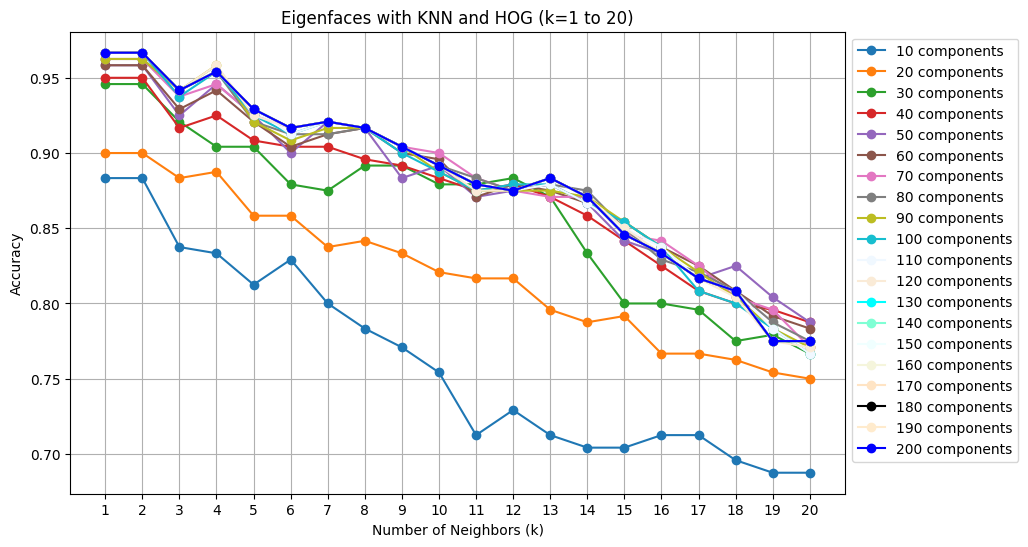

In [4]:
def load_dataset(dataset_path):
    dataset = []
    num_folders = sorted(os.listdir(dataset_path), key=lambda x: int(x))
    
    for num_folder in num_folders:
        num_folder_path = os.path.join(dataset_path, num_folder)
        for img_name in os.listdir(num_folder_path):
            img_path = os.path.join(num_folder_path, img_name)
            img = cv2.imread(img_path)
            flipped = tf.image.flip_left_right(img)
            flipped = np.array(flipped)
            flipped = cv2.cvtColor(flipped, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)           
            img = img/255.0
            dataset.append((img, num_folder))
           
            flipped = flipped/255.0
            dataset.append((flipped, num_folder))
            

    return dataset

dataset_path = "dataset"
dataset = load_dataset(dataset_path)
aux=[]
for img in dataset:
    aux.append(img[0])
data=np.array(aux)

labels=[]
for target in dataset:
    labels.append(target[1])
labels=np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

X_train2=[]
for img in X_train:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_train2.append(hog_image)
X_train2=np.array(X_train2)

X_test2=[]
for img in X_test:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_test2.append(hog_image)
X_test2=np.array(X_test2)

n_samples, height, width = X_train2.shape
X_train = np.reshape(X_train2, (n_samples, height * width))

n_samples, height, width = X_test2.shape
X_test = np.reshape(X_test2, (n_samples, height * width))

pca = PCA()
pca.fit(X_train)

k_range = range(1, 21)

accuracies = []
max_accuracy = 0
best_n_components = 0
best_k = 0
n_components = list(range(10, 201, 10))

for component in n_components:
    eigenfaces = pca.components_[:component]

    weights = eigenfaces @ (X_train - pca.mean_).T

    component_accuracies = []
    for k in k_range:
        accuracy = 0

        for i in range(X_test.shape[0]):
            img_weight = eigenfaces @ (X_test[i].reshape(1, -1) - pca.mean_).T
            euclidean_distance = np.linalg.norm(weights - img_weight, axis=0)
            closest_indices = np.argsort(euclidean_distance)[:k]  # Indices of the k nearest neighbors

            neighbor_labels = [y_train[idx] for idx in closest_indices]

            predicted_label = Counter(neighbor_labels).most_common(1)[0][0]

            if y_test[i] == predicted_label:
                accuracy += 1

        accuracy = accuracy / X_test.shape[0]
        component_accuracies.append(accuracy)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_n_components = component
            best_k = k

    accuracies.append(component_accuracies)

print("Best accuracy:", max_accuracy)
print("Best Components:", best_n_components)
print("Best k:", best_k)

eva_eigenfaces_knn_hog=[max_accuracy,best_n_components,best_k]

colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())[:10]
colors = colors[:20]

plt.figure(figsize=(10, 6))

for i, (component_accuracy, color) in enumerate(zip(accuracies, colors)):
    plt.plot(k_range, component_accuracy, marker='o', color=color, label=f'{n_components[i]} components')

plt.title('Eigenfaces with KNN and HOG (k=1 to 20)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.savefig('evaluation/eigenfaces_knn_hog.png')
plt.show()

## Ilumination levels

Best accuracy: 0.5616666666666666
Best Components: 170
Best k: 1


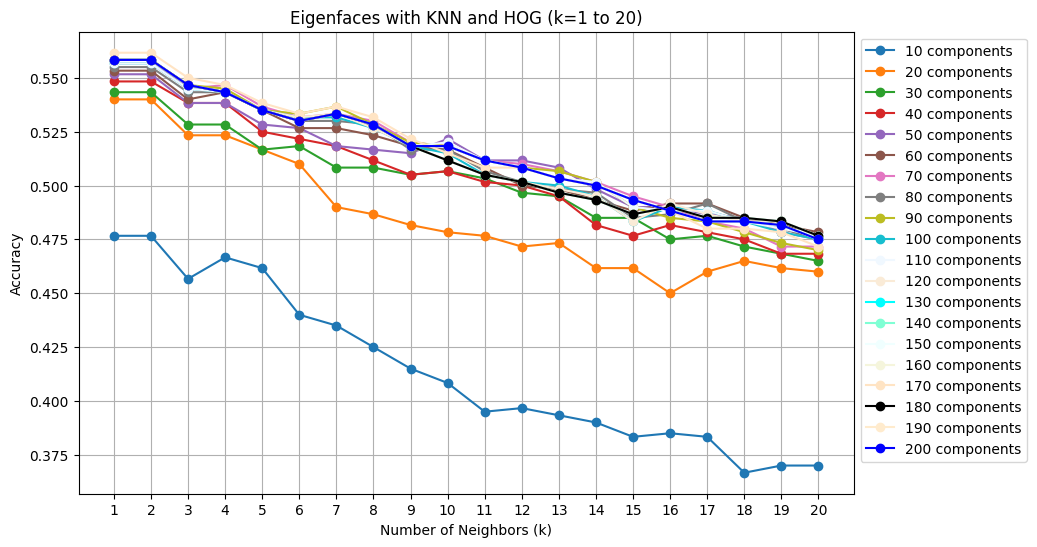

In [5]:
def load_dataset(dataset_path):
    dataset = []
    num_folders = sorted(os.listdir(dataset_path), key=lambda x: int(x))
    
    for num_folder in num_folders:
        num_folder_path = os.path.join(dataset_path, num_folder)
        for img_name in os.listdir(num_folder_path):
            img_path = os.path.join(num_folder_path, img_name)
            img = cv2.imread(img_path)
            flipped = tf.image.flip_left_right(img)
            flipped = np.array(flipped)
            flipped = cv2.cvtColor(flipped, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)           

            random_value = random.uniform(1.2, 1.5)
            increase = np.ones((64, 64)) * random_value
            random_value = random.uniform(0.5, 0.8)
            decrease = np.ones((64, 64)) * 0.65
            
            img = img/255.0
            dataset.append((img, num_folder))
            
            bright_img = np.clip(img * increase, 0, 1)
            dataset.append((bright_img, num_folder))
            
            bright_flipped = np.clip(flipped * increase, 0, 1)
            dataset.append((bright_flipped, num_folder))
            
            bright_img2 = np.clip(img * decrease, 0, 1)
            dataset.append((bright_img2, num_folder))
            
            bright_flipped2 = np.clip(flipped * decrease, 0, 1)
            dataset.append((bright_flipped2, num_folder))

    return dataset

dataset_path = "dataset"
dataset = load_dataset(dataset_path)
aux=[]
for img in dataset:
    aux.append(img[0])
data=np.array(aux)

labels=[]
for target in dataset:
    labels.append(target[1])
labels=np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

X_train2=[]
for img in X_train:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_train2.append(hog_image)
X_train2=np.array(X_train2)

X_test2=[]
for img in X_test:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_test2.append(hog_image)
X_test2=np.array(X_test2)

n_samples, height, width = X_train2.shape
X_train = np.reshape(X_train2, (n_samples, height * width))

n_samples, height, width = X_test2.shape
X_test = np.reshape(X_test2, (n_samples, height * width))

pca = PCA()
pca.fit(X_train)

k_range = range(1, 21)

accuracies = []
max_accuracy = 0
best_n_components = 0
best_k = 0
n_components = list(range(10, 201, 10))

for component in n_components:
    eigenfaces = pca.components_[:component]

    weights = eigenfaces @ (X_train - pca.mean_).T

    component_accuracies = []
    for k in k_range:
        accuracy = 0

        for i in range(X_test.shape[0]):
            img_weight = eigenfaces @ (X_test[i].reshape(1, -1) - pca.mean_).T
            euclidean_distance = np.linalg.norm(weights - img_weight, axis=0)
            closest_indices = np.argsort(euclidean_distance)[:k]  # Indices of the k nearest neighbors

            neighbor_labels = [y_train[idx] for idx in closest_indices]

            predicted_label = Counter(neighbor_labels).most_common(1)[0][0]

            if y_test[i] == predicted_label:
                accuracy += 1

        accuracy = accuracy / X_test.shape[0]
        component_accuracies.append(accuracy)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_n_components = component
            best_k = k

    accuracies.append(component_accuracies)

print("Best accuracy:", max_accuracy)
print("Best Components:", best_n_components)
print("Best k:", best_k)

eva_eigenfaces_knn_hog=[max_accuracy,best_n_components,best_k]

colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())[:10]
colors = colors[:20]

plt.figure(figsize=(10, 6))

for i, (component_accuracy, color) in enumerate(zip(accuracies, colors)):
    plt.plot(k_range, component_accuracy, marker='o', color=color, label=f'{n_components[i]} components')

plt.title('Eigenfaces with KNN and HOG (k=1 to 20)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.savefig('evaluation/eigenfaces_knn_hog.png')
plt.show()

# All data augmentation

Best accuracy: 0.9941666666666666
Best Components: 100
Best k: 1


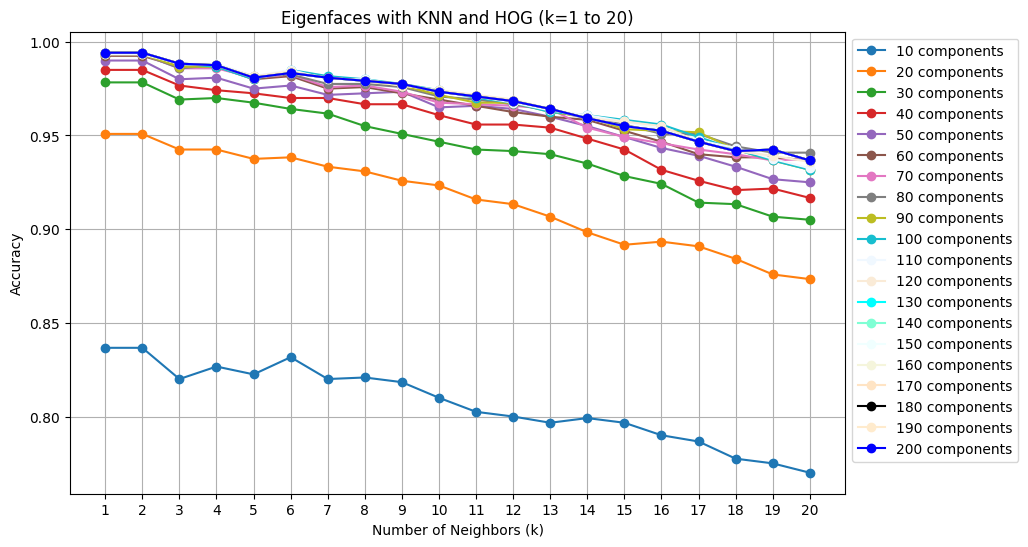

In [3]:
def load_dataset(dataset_path):
    dataset = []
    num_folders = sorted(os.listdir(dataset_path), key=lambda x: int(x))
    
    for num_folder in num_folders:
        num_folder_path = os.path.join(dataset_path, num_folder)
        for img_name in os.listdir(num_folder_path):
            img_path = os.path.join(num_folder_path, img_name)
            img = cv2.imread(img_path)
            flipped = tf.image.flip_left_right(img)
            flipped = np.array(flipped)
            flipped = cv2.cvtColor(flipped, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            random_value = random.uniform(1.2, 1.5)
            increase = np.ones((64, 64)) * random_value
            random_value = random.uniform(0.5, 0.8)
            decrease = np.ones((64, 64)) * 0.65
            
            img = img/255.0
            dataset.append((img, num_folder))
           
            flipped = flipped/255.0
            dataset.append((flipped, num_folder))
            
            bright_img = np.clip(img * increase, 0, 1)
            dataset.append((bright_img, num_folder))
            
            bright_flipped = np.clip(flipped * increase, 0, 1)
            dataset.append((bright_flipped, num_folder))
            
            bright_img2 = np.clip(img * decrease, 0, 1)
            dataset.append((bright_img2, num_folder))
            
            bright_flipped2 = np.clip(flipped * decrease, 0, 1)
            dataset.append((bright_flipped2, num_folder))
            
            random_value = random.uniform(0.02, 0.033)
            noise_img1 = img + np.random.normal(0, random_value, img.shape)
            noise_img1 = np.clip(noise_img1, 0, 1)
            dataset.append((noise_img1, num_folder))

            noise_img2 = flipped + np.random.normal(0, random_value, flipped.shape)
            noise_img2 = np.clip(noise_img2, 0, 1)
            dataset.append((noise_img2, num_folder))
            
            blur_img1 = cv2.GaussianBlur(img, (5, 5), 0)
            dataset.append((blur_img1, num_folder))
            blur_img2 = cv2.GaussianBlur(flipped, (5, 5), 0)
            dataset.append((blur_img2, num_folder))
           
    return dataset

dataset_path = "dataset"
dataset = load_dataset(dataset_path)
aux=[]
for img in dataset:
    aux.append(img[0])
data=np.array(aux)

labels=[]
for target in dataset:
    labels.append(target[1])
labels=np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

X_train2=[]
for img in X_train:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_train2.append(hog_image)
X_train2=np.array(X_train2)

X_test2=[]
for img in X_test:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_test2.append(hog_image)
X_test2=np.array(X_test2)

n_samples, height, width = X_train2.shape
X_train = np.reshape(X_train2, (n_samples, height * width))

n_samples, height, width = X_test2.shape
X_test = np.reshape(X_test2, (n_samples, height * width))

pca = PCA()
pca.fit(X_train)

k_range = range(1, 21)

accuracies = []
max_accuracy = 0
best_n_components = 0
best_k = 0
n_components = list(range(10, 201, 10))

for component in n_components:
    eigenfaces = pca.components_[:component]

    weights = eigenfaces @ (X_train - pca.mean_).T

    component_accuracies = []
    for k in k_range:
        accuracy = 0

        for i in range(X_test.shape[0]):
            img_weight = eigenfaces @ (X_test[i].reshape(1, -1) - pca.mean_).T
            euclidean_distance = np.linalg.norm(weights - img_weight, axis=0)
            closest_indices = np.argsort(euclidean_distance)[:k]  # Indices of the k nearest neighbors

            neighbor_labels = [y_train[idx] for idx in closest_indices]

            predicted_label = Counter(neighbor_labels).most_common(1)[0][0]

            if y_test[i] == predicted_label:
                accuracy += 1

        accuracy = accuracy / X_test.shape[0]
        component_accuracies.append(accuracy)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_n_components = component
            best_k = k

    accuracies.append(component_accuracies)

print("Best accuracy:", max_accuracy)
print("Best Components:", best_n_components)
print("Best k:", best_k)

eva_eigenfaces_knn_hog=[max_accuracy,best_n_components,best_k]

colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())[:10]
colors = colors[:20]

plt.figure(figsize=(10, 6))

for i, (component_accuracy, color) in enumerate(zip(accuracies, colors)):
    plt.plot(k_range, component_accuracy, marker='o', color=color, label=f'{n_components[i]} components')

plt.title('Eigenfaces with KNN and HOG (k=1 to 20)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.savefig('evaluation/eigenfaces_knn_hog.png')
plt.show()

# All data augmentation - bright

Best accuracy: 0.9805555555555555
Best Components: 80
Best k: 1


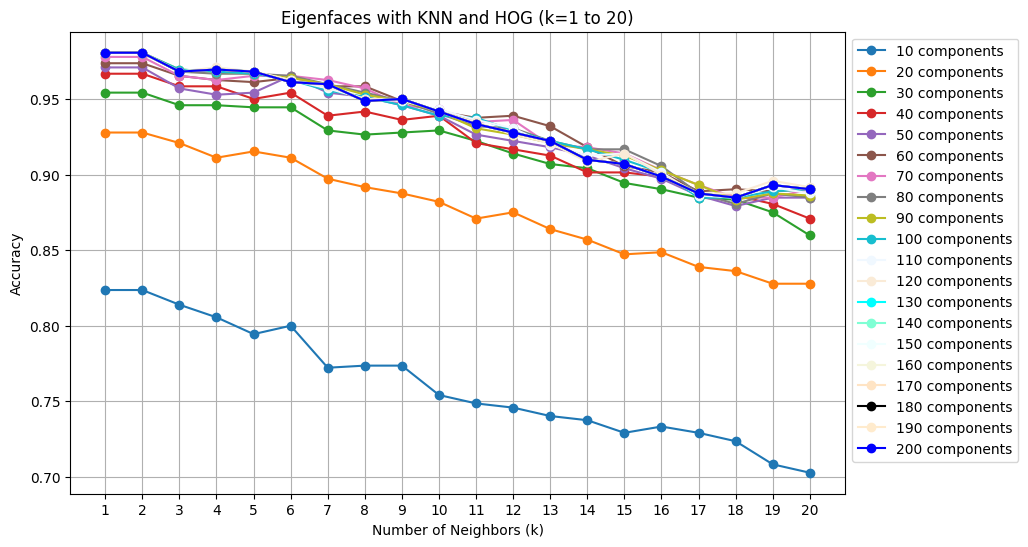

In [4]:
def load_dataset(dataset_path):
    dataset = []
    num_folders = sorted(os.listdir(dataset_path), key=lambda x: int(x))
    
    for num_folder in num_folders:
        num_folder_path = os.path.join(dataset_path, num_folder)
        for img_name in os.listdir(num_folder_path):
            img_path = os.path.join(num_folder_path, img_name)
            img = cv2.imread(img_path)
            flipped = tf.image.flip_left_right(img)
            flipped = np.array(flipped)
            flipped = cv2.cvtColor(flipped, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            random_value = random.uniform(1.2, 1.5)
            increase = np.ones((64, 64)) * random_value
            random_value = random.uniform(0.5, 0.8)
            decrease = np.ones((64, 64)) * 0.65
            
            img = img/255.0
            dataset.append((img, num_folder))
           
            flipped = flipped/255.0
            dataset.append((flipped, num_folder))

            random_value = random.uniform(0.02, 0.033)
            noise_img1 = img + np.random.normal(0, random_value, img.shape)
            noise_img1 = np.clip(noise_img1, 0, 1)
            dataset.append((noise_img1, num_folder))

            noise_img2 = flipped + np.random.normal(0, random_value, flipped.shape)
            noise_img2 = np.clip(noise_img2, 0, 1)
            dataset.append((noise_img2, num_folder))
            
            blur_img1 = cv2.GaussianBlur(img, (5, 5), 0)
            dataset.append((blur_img1, num_folder))
            blur_img2 = cv2.GaussianBlur(flipped, (5, 5), 0)
            dataset.append((blur_img2, num_folder))
           
    return dataset

dataset_path = "dataset"
dataset = load_dataset(dataset_path)
aux=[]
for img in dataset:
    aux.append(img[0])
data=np.array(aux)

labels=[]
for target in dataset:
    labels.append(target[1])
labels=np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

X_train2=[]
for img in X_train:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_train2.append(hog_image)
X_train2=np.array(X_train2)

X_test2=[]
for img in X_test:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)
    X_test2.append(hog_image)
X_test2=np.array(X_test2)

n_samples, height, width = X_train2.shape
X_train = np.reshape(X_train2, (n_samples, height * width))

n_samples, height, width = X_test2.shape
X_test = np.reshape(X_test2, (n_samples, height * width))

pca = PCA()
pca.fit(X_train)

k_range = range(1, 21)

accuracies = []
max_accuracy = 0
best_n_components = 0
best_k = 0
n_components = list(range(10, 201, 10))

for component in n_components:
    eigenfaces = pca.components_[:component]

    weights = eigenfaces @ (X_train - pca.mean_).T

    component_accuracies = []
    for k in k_range:
        accuracy = 0

        for i in range(X_test.shape[0]):
            img_weight = eigenfaces @ (X_test[i].reshape(1, -1) - pca.mean_).T
            euclidean_distance = np.linalg.norm(weights - img_weight, axis=0)
            closest_indices = np.argsort(euclidean_distance)[:k]  # Indices of the k nearest neighbors

            neighbor_labels = [y_train[idx] for idx in closest_indices]

            predicted_label = Counter(neighbor_labels).most_common(1)[0][0]

            if y_test[i] == predicted_label:
                accuracy += 1

        accuracy = accuracy / X_test.shape[0]
        component_accuracies.append(accuracy)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_n_components = component
            best_k = k

    accuracies.append(component_accuracies)

print("Best accuracy:", max_accuracy)
print("Best Components:", best_n_components)
print("Best k:", best_k)

eva_eigenfaces_knn_hog=[max_accuracy,best_n_components,best_k]

colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())[:10]
colors = colors[:20]

plt.figure(figsize=(10, 6))

for i, (component_accuracy, color) in enumerate(zip(accuracies, colors)):
    plt.plot(k_range, component_accuracy, marker='o', color=color, label=f'{n_components[i]} components')

plt.title('Eigenfaces with KNN and HOG (k=1 to 20)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.savefig('evaluation/eigenfaces_knn_hog.png')
plt.show()